In [225]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

from os import listdir
from os.path import isfile, join

import re

In [226]:
def removeExtension(file_name):
    idx = -1
    for i, c in enumerate(file_name):
        if c == '.':
            idx = i
            break
    if idx >= 0:
        return file_name[:idx]
    return file_name

In [247]:
SUBMISSIONS_DIR = './submissions/'
MATCH_RESULTS_DIR = './match_results/'

In [228]:
files = sorted([f for f in listdir(SUBMISSIONS_DIR) if isfile(join(SUBMISSIONS_DIR, f)) and f[-1] != 'c'])
names = sorted([removeExtension(f) for f in files])

teams = list(zip(files, names))

In [229]:
match_results_df = pd.DataFrame(columns=['Team', 'Opponent', 'Wins', 'Losses', 'Ties', 'Invalid'])

In [230]:
def process_raw_outcome(outcome):
    return outcome.replace('\n', '')

for i in range(len(teams)):
    for j in range(i + 1, len(teams)):
        if i == j:
            continue
        
        file_a, name_a = teams[i]
        file_b, name_b = teams[j]
        
        # Get match results for team a vs team b
        match_data_file_name = name_a + '_vs_' + name_b + '.dat'
        try:
            match_data_file = open(join(MATCH_RESULTS_DIR, match_data_file_name), 'r')
        except FileNotFoundError:
            continue
        outcomes = [process_raw_outcome(l) for l in match_data_file]
        outcomes = outcomes[:15]
        match_data_file.close()
        
        # Get DataFrame props
        num_rows, num_cols = match_results_df.shape
        
        # Insert row if doesn't exist or reset row
        index_a, index_b = -1, -1
        for k in range(num_rows):
            row = match_results_df.loc[k]
            if row.Team == name_a and row.Opponent == name_b:
                index_a = k
            if row.Team == name_b and row.Opponent == name_a:
                index_b = k
        if index_a == -1 and index_b == -1:
            index_a, index_b = num_rows, num_rows + 1
        elif index_a == -1:
            index_a = num_rows
        elif index_b == -1:
            index_b == num_rows
        
        win, loss, tied, invalid = 0, 0, 0, 0
        for outcome in outcomes:
            if outcome == name_a:
                win += 1
            elif outcome == name_b:
                loss += 1
            elif outcome == 'tied':
                tied += 1
            elif outcome == 'invalid':
                invalid += 1
            else:
                raise Error('Invalid match outcome')
        match_results_df.loc[index_a] = [name_a, name_b, win, loss, tied, invalid]
        match_results_df.loc[index_b] = [name_b, name_a, loss, win, tied, invalid]

In [231]:
match_results_df.shape

(1024, 6)

In [232]:
match_results_df.head()

,Team,Opponent,Wins,Losses,Ties,Invalid
0,PacBot_Kevin_Cao,baselineTeam2_Rachel_Li,8,7,0,0
1,baselineTeam2_Rachel_Li,PacBot_Kevin_Cao,7,8,0,0
2,PacBot_Kevin_Cao,baselineTeam2_Raghav_Anand,9,6,0,0
3,baselineTeam2_Raghav_Anand,PacBot_Kevin_Cao,6,9,0,0
4,PacBot_Kevin_Cao,cleverTeam_Dylan_Rowe,12,3,0,0


In [233]:
match_results_df[match_results_df['Invalid'] > 10].shape

(302, 6)

# Invalid Submissions

In [234]:
invalid_dict = dict(zip(names, [0] * len(names)))
for file, name in teams:
    invalids = match_results_df[(match_results_df['Invalid'] > 10) & (match_results_df['Team'] == name)].shape[0]
    invalid_dict[name] += invalids
    
INVALID_THRESH = 30
invalid_list = [name for name in names if invalid_dict[name] > INVALID_THRESH]
invalid_list

['contest_ANISH_SAHA', 'contest_ANISH_SAHA_1']

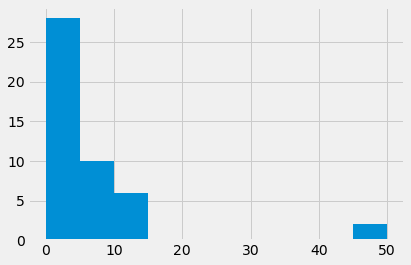

In [235]:
plt.hist(list(invalid_dict.values()), bins=np.arange(0, 55, 5))
plt.show()

# Elo

In [236]:
elo_dict = dict(zip(names, [1500] * len(names)))

In [237]:
match_results_df['margin'] = match_results_df.Wins - match_results_df.Losses

In [238]:
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

def expected_margin(elo_diff):
    return((7.5 + 0.006 * elo_diff))

def elo_update(w_elo, l_elo, margin, K=20):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return(pred, update)

In [239]:
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in match_results_df.itertuples():
    # Get key data from current row
    w = row.Team
    l = row.Opponent
    margin = row.margin
    
    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w],
                              elo_dict[l], 
                              margin)
    elo_dict[w] += update
    elo_dict[l] -= update
    
    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

In [240]:
win_elo = []
for w in w_elo:
    if isinstance(w, complex):
        win_elo.append(w.real)
    else:
        win_elo.append(w)
        
loss_elo = []
for l in l_elo:
    if isinstance(l, complex):
        loss_elo.append(l.real)
    else:
        loss_elo.append(l)

In [241]:
match_results_df['w_elo'] = win_elo
match_results_df['l_elo'] = loss_elo

In [242]:
match_results_df.tail(10)

,Team,Opponent,Wins,Losses,Ties,Invalid,margin,w_elo,l_elo
1014,myTeam3_5foodNum_ALI_KHALEEL_AHMED,myTeam3_ALI_KHALEEL_AHMED,8,2,5,0,6,1542.540776,1503.937229
1015,myTeam3_ALI_KHALEEL_AHMED,myTeam3_5foodNum_ALI_KHALEEL_AHMED,2,8,5,0,-6,1501.028473,1545.449532
1016,myTeam3_5foodNum_ALI_KHALEEL_AHMED,myTeam3_ALI_KHALEEL_AHMED_1,11,2,2,0,9,1553.930283,1500.961830
1017,myTeam3_ALI_KHALEEL_AHMED_1,myTeam3_5foodNum_ALI_KHALEEL_AHMED,2,11,2,0,-9,1495.647549,1559.244563
1018,myTeam3_5foodNum_ALI_KHALEEL_AHMED,myTeam3_ALI_KHALEEL_AHMED_2,6,6,3,0,0,1561.713170,1490.219360
1019,myTeam3_ALI_KHALEEL_AHMED_2,myTeam3_5foodNum_ALI_KHALEEL_AHMED,6,6,3,0,0,1494.314935,1557.617595
1020,myTeam3_5foodNum_ALI_KHALEEL_AHMED,myTeam3_ALI_KHALEEL_AHMED_3,8,3,4,0,5,1563.160085,1491.150860
1021,myTeam3_ALI_KHALEEL_AHMED_3,myTeam3_5foodNum_ALI_KHALEEL_AHMED,3,8,4,0,-5,1488.806772,1565.504173
1022,myTeam3_5foodNum_ALI_KHALEEL_AHMED,myTeam3_ALI_KHALEEL_AHMED_4,1,0,1,13,1,1568.671806,1500.249867
1023,myTeam3_ALI_KHALEEL_AHMED_4,myTeam3_5foodNum_ALI_KHALEEL_AHMED,0,1,1,13,-1,1503.182728,1565.738945


In [243]:
final_elo_dict = dict(zip(names, [1500] * len(names)))

In [244]:
for row in match_results_df.itertuples():
    final_elo_dict[row.Team] = row.w_elo
    final_elo_dict[row.Opponent] = row.l_elo

In [245]:
rankings = zip(final_elo_dict.keys(), final_elo_dict.values())
rankings = [r for r in rankings if r[0] not in invalid_list]
rankings = sorted(list(rankings), key=lambda x: -x[1])
place = 1
for name, elo in rankings:
    print('%d.' %place, name, '(%.3f)' % elo)
    place += 1

1. myTeam3_4foodNum_ALI_KHALEEL_AHMED (1712.268)
2. myTeam2_ALI_KHALEEL_AHMED (1601.422)
3. myTeam2_SEAN_ADAM_MEDIN (1592.659)
4. myTeam2_ALI_KHALEEL_AHMED_1 (1590.406)
5. myTeam2_5foodNum_ALI_KHALEEL_AHMED (1582.101)
6. myTeam2_4foodNum_ALI_KHALEEL_AHMED (1572.785)
7. myTeam3_5foodNum_ALI_KHALEEL_AHMED (1565.739)
8. myTeam_Christina_Baek_1 (1560.962)
9. myTeam_Laura_Smith (1559.369)
10. myTeam_Swapnil_Das_1 (1555.219)
11. myTeam3_ALI_KHALEEL_AHMED_6 (1547.755)
12. myTeam_Christina_Baek (1546.305)
13. myTeam_Joshua_Yurtsever (1538.778)
14. myTeam_Swapnil_Das (1531.558)
15. myTeam_Xing_Jin (1515.671)
16. myTeam_SHARABESH_RAMESH (1511.100)
17. myTeam3_ALI_KHALEEL_AHMED_5 (1505.252)
18. myTeam3_ALI_KHALEEL_AHMED_4 (1503.183)
19. myTeam3_ALI_KHALEEL_AHMED (1501.028)
20. myTeam_Colin_K_Lai_1 (1498.862)
21. myTeam_Benjamin_Carlson (1497.532)
22. myTeam_Benjamin_Carlson_1 (1497.510)
23. myTeam_Colin_K_Lai (1497.254)
24. myTeam3_ALI_KHALEEL_AHMED_1 (1495.648)
25. myTeam3_ALI_KHALEEL_AHMED_2 (1

# Manual Investigation

In [250]:
match_results_df[match_results_df['Team'] == 'veryCleverTeam_Gao_Xian_Peh']

,Team,Opponent,Wins,Losses,Ties,Invalid,margin,w_elo,l_elo
89,veryCleverTeam_Gao_Xian_Peh,PacBot_Kevin_Cao,1,4,10,0,-3,1493.662225,1470.934916
177,veryCleverTeam_Gao_Xian_Peh,baselineTeam2_Rachel_Li,1,3,10,1,-2,1488.972033,1444.545203
263,veryCleverTeam_Gao_Xian_Peh,baselineTeam2_Raghav_Anand,0,3,12,0,-3,1481.810157,1423.109016
347,veryCleverTeam_Gao_Xian_Peh,cleverTeam_Dylan_Rowe,1,2,12,0,-1,1478.926846,1432.150131
429,veryCleverTeam_Gao_Xian_Peh,contest_ANISH_SAHA,0,0,0,15,0,1479.558237,1501.992760
509,veryCleverTeam_Gao_Xian_Peh,contest_ANISH_SAHA_1,0,0,0,15,0,1480.175050,1502.015167
587,veryCleverTeam_Gao_Xian_Peh,coolTeam_SONTHAYA_VISUTHIKRAISEE,0,0,15,0,0,1480.331844,1483.452516
663,veryCleverTeam_Gao_Xian_Peh,myTeam2_4foodNum_ALI_KHALEEL_AHMED,0,11,2,2,-11,1464.647519,1572.785335
737,veryCleverTeam_Gao_Xian_Peh,myTeam2_5foodNum_ALI_KHALEEL_AHMED,0,9,5,1,-9,1452.013441,1582.100616
809,veryCleverTeam_Gao_Xian_Peh,myTeam2_ALI_KHALEEL_AHMED,1,8,6,0,-7,1442.509380,1601.421811
